In [1]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr
ro.r('library(forecast)')
ro.r('library(stats)')

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')
Trying to import in ABI mode.
R callback write-console: Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
  
R callback write-console: This is forecast 8.24.0 
  Want to meet other forecasters? Join the International Institute of Forecasters:
  http://forecasters.org/
  


In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error # <-- IMPORTAR MÉTRICAS
# Regular packages
import pandas as pd
import sys
from pathlib import Path
import os
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsforecast.models import AutoETS
from statsforecast import StatsForecast

# adds src folder to path
sys.path.append(str(Path.cwd().parent.parent / "src")) # Necessário contar quantos niveis subir nas pastas, incluir 1 .parent para cada nivel.

# My custom functions and classes
from utils.paths import resolve_env_path, PROJECT_ROOT
from classes.time_series_dataset import TimeSeriesDataset
from classes.plotter import Plotter
from utils.calculations import plot_stl_decomposition
from utils.calculations import process_df

# Nixlaverse model utilities
from hierarchicalforecast.core import HierarchicalReconciliation
# from hierarchicalforecast.evaluation import evaluate
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss, mape
# from statsforecast.models import AutoETS
# from statsforecast import StatsForecast



# Adiciona caminhos importantes
ARRIVALS_PATH = resolve_env_path("ARRIVALS_PATH")

# Selecting seaborn theme
sns.set_theme(
    style="ticks",
    palette="bright",
    context="notebook"
)

c:\Users\Dog\AppData\Local\Programs\Python\Python313\Lib\site-packages\fs\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore


Carregar Banco de Dados.

In [3]:
arrivals_dataset = TimeSeriesDataset(ARRIVALS_PATH)
df = arrivals_dataset.get_data_without_missing_values()

Filtrar viajens com destino ao Rio de Janeiro

In [4]:
df_rj = process_df(
    df=df,
    state="rio_de_janeiro",
    value_cols="arrivals",
    agg_func="sum",
    agg_cols="date"
)
df_rj.tail()

,date,arrivals
295,2024-08-01,91504.0
296,2024-09-01,116003.0
297,2024-10-01,130985.0
298,2024-11-01,145148.0
299,2024-12-01,176121.0


Criar banco de dados para análise temporal

In [5]:
df_rj['date'] = pd.to_datetime(df_rj['date'])
df_rj = df_rj.set_index('date')
df_rj = df_rj.sort_index()
df_rj = df_rj.asfreq('MS')
data_series = df_rj['arrivals']
data_series

date
2000-01-01     91318.0
2000-02-01     80424.0
2000-03-01     75716.0
2000-04-01     62957.0
2000-05-01     53855.0
                ...   
2024-08-01     91504.0
2024-09-01    116003.0
2024-10-01    130985.0
2024-11-01    145148.0
2024-12-01    176121.0
Freq: MS, Name: arrivals, Length: 300, dtype: float64

Definir Período da covid.

In [6]:
PRE_COVID_END = '2020-02-29' # Último dia antes do impacto
COVID_START = '2020-03-01' # Primeiro dia do impacto
COVID_END = '2021-12-31'   # Último dia do período a ser imputado
dados_pre_covid = data_series.loc[:PRE_COVID_END].copy()

Fazer uma decomposição STL para realizar a imputação.

In [7]:
stl = STL(dados_pre_covid, period=12, seasonal=13).fit()

Projetar Componente Sazonalidade, Tendência e Combiná-los para imputar o período da covid

In [8]:
ultimo_ano_sazonal = stl.seasonal[-12:]
indice_gap_covid = data_series.loc[COVID_START:COVID_END].index
n_meses_gap = len(indice_gap_covid)

n_repeticoes = int(np.ceil(n_meses_gap / 12))
valores_sazonais_projetados = np.tile(ultimo_ano_sazonal.values, n_repeticoes)[:n_meses_gap]

sazonal_imputado = pd.Series(valores_sazonais_projetados, index=indice_gap_covid)


segmento_tendencia_recente = stl.trend.dropna().iloc[-12:]

x = np.arange(len(segmento_tendencia_recente))
y = segmento_tendencia_recente.values
coefs = np.polyfit(x, y, 1) # Retorna [slope, intercept]
slope = coefs[0]

ultimo_valor_tendencia = segmento_tendencia_recente.iloc[-1]
x_projecao = np.arange(1, n_meses_gap + 1)
valores_tendencia_projetados = (slope * x_projecao) + ultimo_valor_tendencia

tendencia_imputada = pd.Series(valores_tendencia_projetados, index=indice_gap_covid)


valores_imputados = tendencia_imputada + sazonal_imputado
data_series_imputada = data_series.copy()
data_series_imputada.loc[COVID_START:COVID_END] = valores_imputados
data_series_imputada

date
2000-01-01     91318.0
2000-02-01     80424.0
2000-03-01     75716.0
2000-04-01     62957.0
2000-05-01     53855.0
                ...   
2024-08-01     91504.0
2024-09-01    116003.0
2024-10-01    130985.0
2024-11-01    145148.0
2024-12-01    176121.0
Freq: MS, Name: arrivals, Length: 300, dtype: float64

Plot da Comparação da Imputação com o Período Original.

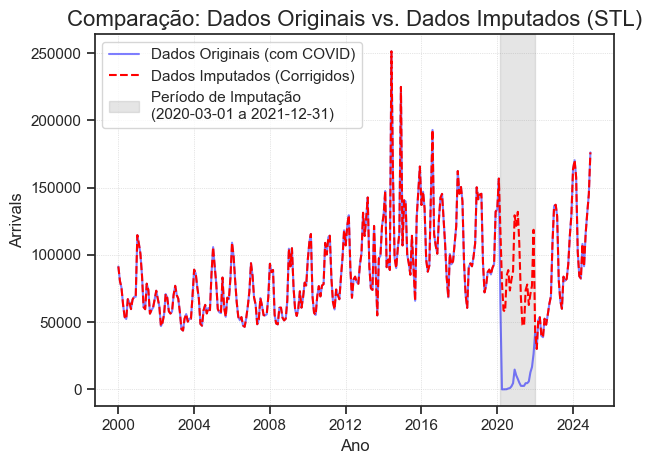

In [9]:
plt.plot(data_series.index, data_series, label='Dados Originais (com COVID)', 
         color='blue', alpha=0.5)

# Plota os novos dados imputados
plt.plot(data_series_imputada.index, data_series_imputada, 
         label='Dados Imputados (Corrigidos)', 
         color='red', linestyle='--')

# Destaca a área que foi imputada
plt.axvspan(pd.to_datetime(COVID_START), pd.to_datetime(COVID_END), 
            color='gray', alpha=0.2, label=f'Período de Imputação\n({COVID_START} a {COVID_END})')

plt.title('Comparação: Dados Originais vs. Dados Imputados (STL)', fontsize=16)
plt.ylabel(data_series.name.capitalize() if data_series.name else 'Valores')
plt.xlabel('Ano')
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.tight_layout()
plt.show()

ETS no R, com dataset original

In [10]:
with localconverter(ro.default_converter + pandas2ri.converter):
    df_r = ro.conversion.py2rpy(data_series)

serie_temporal_r = ro.r.ts(df_r, 
                                start=[2000,1], 
                                frequency=12)

print(serie_temporal_r)

treino = ro.r.head(serie_temporal_r, n=-12)

modelo_ets = ro.r.ets(treino)

previsao_r = ro.r.forecast(modelo_ets, h=12)





# Converte o objeto R 'previsao_r' para um DataFrame pandas
with localconverter(ro.default_converter + pandas2ri.converter):
    mean = ro.conversion.rpy2py(previsao_r.rx2('mean'))      # previsões pontuais
    lower = ro.conversion.rpy2py(previsao_r.rx2('lower'))    # limites inferiores (matriz)
    upper = ro.conversion.rpy2py(previsao_r.rx2('upper'))    # limites superiores (matriz)
    levels = list(previsao_r.rx2('level'))                   # níveis de confiança (ex: [80,95])

# Garante que lower/upper tenham duas dimensões
lower = np.atleast_2d(lower)
upper = np.atleast_2d(upper)

# Cria índice de datas para o horizonte de previsão a partir da última data dos dados (df_ets)
last_date = pd.Timestamp('2023-12-01')
start = last_date + pd.offsets.MonthBegin(1)
periods = len(mean)
idx = pd.date_range(start=start, periods=periods, freq='MS')

# Monta o DataFrame final com colunas para média e intervalos de confiança
forecast_df = pd.DataFrame({'ds': idx, 'forecast': mean})
for i, lvl in enumerate(levels):
    forecast_df[f'lower_{int(lvl)}'] = lower[:, i]
    forecast_df[f'upper_{int(lvl)}'] = upper[:, i]



        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
2000  91318  80424  75716  62957  53855  52278  67061  64874  59626  66774
2001 114615 107891 100995  84549  61234  59574  78543  73986  56266  58872
2002  73318  66973  61748  47035  49495  55748  70877  68161  57979  56317
2003  76971  70003  67437  57416  44763  43701  52658  55955  50309  52607
2004  88969  86045  76117  67457  48664  47301  58762  62802  56422  60496
2005 105732  91165  79298  59718  57254  56667  83108  60832  53960  68175
2006 109025  98499  81265  64811  53855  51338  53730  47428  46483  52905
2007  93770  84175  68420  62934  48396  51953  67885  62353  55140  54949
2008  93335  87134  88747  55426  48925  48328  60618  60773  53170  51225
2009 104561  91448 104937  75300  59395  54564  59949  72893  60702  68274
2010  96660 109875 115466  69266  56915  55296  69000  76722  69072  77160
2011 100232 113131 114213  82379  64714  59397  74229  70459  66987  82986
2012 107029 121752 129423

ETS no R, com versão imputada

In [11]:
with localconverter(ro.default_converter + pandas2ri.converter):
    df_ri = ro.conversion.py2rpy(data_series_imputada)

serie_temporal_ri = ro.r.ts(df_ri, 
                                start=[2000,1], 
                                frequency=12)

treinoi = ro.r.head(serie_temporal_ri, n=-12)

modelo_etsi = ro.r.ets(treinoi)

previsao_ri = ro.r.forecast(modelo_etsi, h=12)

with localconverter(ro.default_converter + pandas2ri.converter):
    mean = ro.conversion.rpy2py(previsao_ri.rx2('mean'))      # previsões pontuais
    lower = ro.conversion.rpy2py(previsao_ri.rx2('lower'))    # limites inferiores (matriz)
    upper = ro.conversion.rpy2py(previsao_ri.rx2('upper'))    # limites superiores (matriz)
    levels = list(previsao_ri.rx2('level'))                   # níveis de confiança (ex: [80,95])

# Garante que lower/upper tenham duas dimensões
lower = np.atleast_2d(lower)
upper = np.atleast_2d(upper)

# Cria índice de datas para o horizonte de previsão a partir da última data dos dados (df_ets)
last_date = pd.Timestamp('2023-12-31')
start = last_date + pd.offsets.MonthBegin(1)
periods = len(mean)
idx = pd.date_range(start=start, periods=periods, freq='MS')

# Monta o DataFrame final com colunas para média e intervalos de confiança
forecast_dfi = pd.DataFrame({'ds': idx, 'forecast': mean})
for i, lvl in enumerate(levels):
    forecast_dfi[f'lower_{int(lvl)}'] = lower[:, i]
    forecast_dfi[f'upper_{int(lvl)}'] = upper[:, i]



In [12]:
forecast_dates = pd.to_datetime(forecast_df['ds'])
y_pred = forecast_df['forecast'].values
y_predi = forecast_dfi['forecast'].values
y_true = data_series.reindex(forecast_dates).values  # alinha pelos índices de data

# Retorna tabela comparativa para inspeção
comparison = pd.DataFrame({'ds': forecast_dates, 'y_true': y_true, 'y_pred': y_pred, 'y_predi': y_predi}).set_index('ds')
comparison

,y_true,y_pred,y_predi
ds,,,
2024-01-01,163598.0,144968.304603,144482.607359
2024-02-01,170305.0,126521.926030,139417.386887
2024-03-01,157683.0,111490.348927,128083.595380
2024-04-01,102172.0,78863.241239,94220.894420
2024-05-01,84116.0,60233.032259,74246.324751
2024-06-01,82402.0,73630.857630,89422.269346
2024-07-01,108089.0,82625.034570,105806.591779
2024-08-01,91504.0,76752.918345,100906.641979
2024-09-01,116003.0,67291.470683,87691.226682


Plot dos valores observados vs previstos e cálculo de MAPE e RMSE

RMSE: 34948.11
MAPE: 24.94%
RMSEi: 25754.56
MAPEi: 15.95%


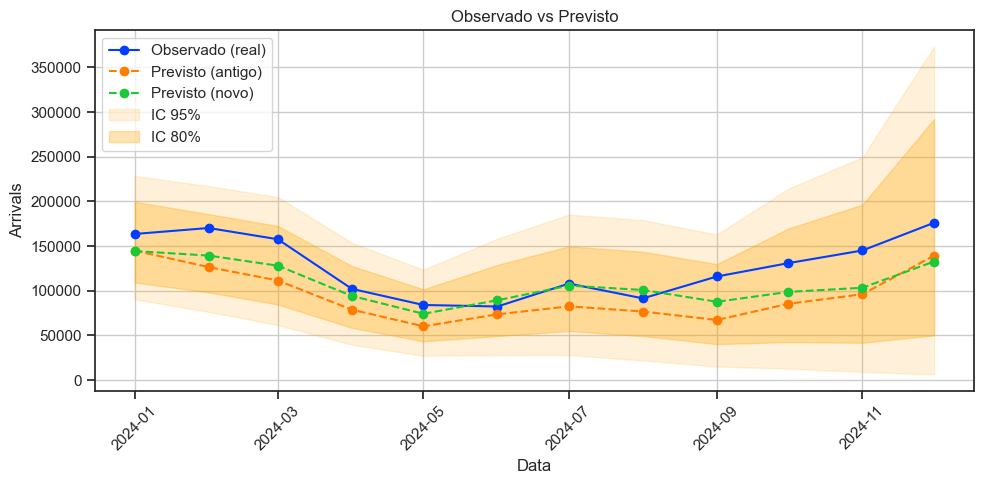

In [14]:
rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))  # RMSE
mape_val = mean_absolute_percentage_error(y_true, y_pred) * 100  # MAPE em %

rmse_vali = np.sqrt(mean_squared_error(y_true, y_predi))  # RMSE
mape_vali = mean_absolute_percentage_error(y_true, y_predi) * 100

print(f"RMSE: {rmse_val:.2f}")
print(f"MAPE: {mape_val:.2f}%")

print(f"RMSEi: {rmse_vali:.2f}")
print(f"MAPEi: {mape_vali:.2f}%")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(comparison.index, y_true, label="Observado (real)", marker="o")
plt.plot(comparison.index, y_pred, label="Previsto (antigo)", marker="o", linestyle="--")
plt.plot(comparison.index, y_predi, label="Previsto (novo)", marker="o", linestyle="--")
# Plota intervalos de confiança (95% e 80%) usando as colunas já calculadas em forecast_df
plt.fill_between(comparison.index, forecast_dfi['lower_95'].values, forecast_df['upper_95'].values,
                 color='orange', alpha=0.15, label='IC 95%')
plt.fill_between(comparison.index, forecast_dfi['lower_80'].values, forecast_df['upper_80'].values,
                 color='orange', alpha=0.30, label='IC 80%')
plt.xlabel("Data")
plt.ylabel("Arrivals")
plt.title("Observado vs Previsto")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()